# Subpockets vs. conformations

Check if our `kissim` subpockets are reasonable across different kinase conformations.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd

from opencadd.structure.pocket import Pocket
from opencadd.databases.klifs import setup_remote
from opencadd.databases.klifs.utils import metadata_to_filepath

## Data retrieval

In [3]:
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


BRAF structures in different conformations taken from [Ung _et al._ (2018)](https://www.sciencedirect.com/science/article/pii/S2451945618301491).

|             | aC-in        | aC-out       |
|-------------|--------------|--------------|
| __DFG-in__  | 2FB8 _CIDI_  | 4EHG _CODI_  |
| __DFG-out__ | 1UWH _CIDO_  | 4XV9 _CODO_  |


### Select structures (PDB IDs, conformation)

In [4]:
structures_selected = pd.DataFrame(
    {"structure.ung_conformation": ["CIDI", "CIDO", "CODI", "CODO"], "structure.pdb": ["2fb8", "4ehg", "1uwh", "4xv9"]}
)

### Query KLIFS for first structure entries per PDB ID

In [5]:
pdb_ids = structures_selected["structure.pdb"].to_list()
structures = remote.structures.from_structure_pdbs(pdb_ids)
print(f"Number of structures: {structures.shape[0]}")
structures.groupby(["structure.dfg", "structure.ac_helix"]).size()

Number of structures: 8


structure.dfg  structure.ac_helix
in             in                    2
               out                   3
               out-like              1
out            out                   2
dtype: int64

KLIFS conformation annotation differs from Ung _et al._.

__KLIFS definitions__:

* aC helix conformation: Distance between the Ca atoms of residue 82 (DFG) and conserved residue 24 (aC helix).
  * aC-in: $[4, 7.2]$
  * aC-out: $>9.3$
  * aC-out-like: $[7.2, 9.3]$
* DFG conformation: Manually.

In [6]:
# Select first structure per PDB ID
structures = structures.groupby("structure.pdb", sort=False).first().reset_index()
structures

structure.pdb  structure.id structure.alternate_model structure.chain  \
0          1uwh          3127                         -               A   
1          2fb8          3062                         -               A   
2          4ehg          3078                         -               B   
3          4xv9          6215                         B               A   

  species.klifs  kinase.id kinase.name kinase.family kinase.group  \
0         Human        509        BRAF          None         None   
1         Human        509        BRAF          None         None   
2         Human        509        BRAF          None         None   
3         Human        509        BRAF          None         None   

                                       kinase.pocket ligand.pdb  \
0  QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...        BAX   
1  QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...        215   
2  QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...        RI9   
3  QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...        1OO   

  ligand.pdb_allosteric ligand.name ligand.name_allosteric structure.dfg  \
0                     -        None                   None           out   
1                     -        None                   None            in   
2                     -        None                   None            in   
3                     -        None                   None            in   

  structure.ac_helix  structure.resolution  structure.qualityscore  \
0                out                  2.95                     7.2   
1                 in                  2.90                     8.0   
2                out                  3.50                     7.6   
3                out                  2.00                     6.4   

   structure.missing_residues  structure.missing_atoms  structure.rmsd1  \
0                           0                        0            1.025   
1                           0                        0            0.780   
2                           1                        0            0.817   
3                           0                        0            1.131   

   structure.rmsd2  structure.front  structure.gate  structure.back  \
0            2.406             True            True            True   
1            2.122             True            True           False   
2            2.133             True            True            True   
3            2.578             True            True            True   

   structure.fp_i  structure.fp_ii  structure.bp_i_a  structure.bp_i_b  \
0           False            False             False              True   
1           False            False             False              True   
2           False            False              True              True   
3           False            False              True              True   

   structure.bp_ii_in  structure.bp_ii_a_in  structure.bp_ii_b_in  \
0               False                 False                 False   
1               False                 False                 False   
2                True                  True                 False   
3               False                 False                 False   

   structure.bp_ii_out  structure.bp_ii_b  structure.bp_iii  structure.bp_iv  \
0                 True              False              True            False   
1                False              False             False            False   
2                False              False             False            False   
3                False              False              True            False   

   structure.bp_v  structure.grich_distance  structure.grich_angle  \
0           False                   18.1196                58.1523   
1           False                   15.1411                51.1305   
2           False                   16.0046                51.4372   
3           False                   15.8575                52.8981   

   structur

### Add KLIFS details to selected structures

In [7]:
structures_selected = structures_selected.merge(
    structures[
        [
            "structure.id", 
            "structure.pdb", 
            "structure.dfg", 
            "structure.ac_helix", 
            "species.klifs", 
            "kinase.name",  
            "structure.alternate_model",
            "structure.chain"
        ]
    ], 
    on="structure.pdb", 
    how="left"
)
structures_selected

structure.ung_conformation structure.pdb  structure.id structure.dfg  \
0                       CIDI          2fb8          3062            in   
1                       CIDO          4ehg          3078            in   
2                       CODI          1uwh          3127           out   
3                       CODO          4xv9          6215            in   

  structure.ac_helix species.klifs kinase.name structure.alternate_model  \
0                 in         Human        BRAF                         -   
1                out         Human        BRAF                         -   
2                out         Human        BRAF                         -   
3                out         Human        BRAF                         B   

  structure.chain  
0               A  
1               B  
2               A  
3               A

### Download structure files from KLIFS

In [8]:
# Download files
for _, structure in structures_selected.iterrows():
    remote.coordinates.to_file(structure["structure.id"], ".", "protein")

In [9]:
# Add file path
structures_selected["structure.filepath"] = structures_selected.apply(
    lambda x: metadata_to_filepath(
        ".", 
        x["species.klifs"], 
        x["kinase.name"], 
        x["structure.pdb"],
        x["structure.alternate_model"], 
        x["structure.chain"],
        "protein"
    ), 
    axis=1
)

In [10]:
structures_selected

structure.ung_conformation structure.pdb  structure.id structure.dfg  \
0                       CIDI          2fb8          3062            in   
1                       CIDO          4ehg          3078            in   
2                       CODI          1uwh          3127           out   
3                       CODO          4xv9          6215            in   

  structure.ac_helix species.klifs kinase.name structure.alternate_model  \
0                 in         Human        BRAF                         -   
1                out         Human        BRAF                         -   
2                out         Human        BRAF                         -   
3                out         Human        BRAF                         B   

  structure.chain                        structure.filepath  
0               A       HUMAN_BRAF_2fb8_chainA_protein.mol2  
1               B       HUMAN_BRAF_4ehg_chainB_protein.mol2  
2               A       HUMAN_BRAF_1uwh_chainA_protein.mol2  
3               A  HUMAN_BRAF_4xv9_altB_chainA_protein.mol2

## Show subpockets

In [11]:
KINASE_SUBPOCKETS = pd.DataFrame(
    [
        ["hinge_region", "magenta", [16, 47, 80]],
        ["dfg_region", "cornflowerblue", [19, 24, 81]],  # salt brige 17-24, aC distance 24-82
        ["front_pocket", "cyan", [6, 48, 75]]
    ],
    columns=["name", "color", "klifs_ids"]
)

In [12]:
def visualize_kinase(structure_id, filepath, subpockets, name):

    # Pocket residues
    pocket_residues = remote.pockets.from_structure_id(structure_id)

    # Set up pocket
    pocket = Pocket.from_file(
        filepath, 
        name, 
        pocket_residues["residue.pdb_id"].to_list(), 
        pocket_residues["residue.klifs_id"].to_list()
    )

    # Add subpockets
    for _, subpocket in subpockets.iterrows(): 
        pocket.add_subpocket(
            subpocket["name"], 
            subpocket["color"], 
            pocket_residues[
                pocket_residues["residue.klifs_id"].isin(subpocket["klifs_ids"])
            ]["residue.pdb_id"].to_list(), 
            subpocket["klifs_ids"]
        )

    # Add regions
    for (region, color), group in pocket_residues.groupby(["residue.klifs_region_id", "residue.klifs_color"]):
        pocket.add_region(
            region, 
            color, 
            group["residue.pdb_id"].to_list(), 
            group["residue.klifs_region_id"].to_list()
        )

    # Visualize
    view = pocket.visualize()
    
    return view

### CIDI (KLIFS: CIDI) structure

In [13]:
structure = structures_selected.iloc[0]
structure

structure.ung_conformation                                   CIDI
structure.pdb                                                2fb8
structure.id                                                 3062
structure.dfg                                                  in
structure.ac_helix                                             in
species.klifs                                               Human
kinase.name                                                  BRAF
structure.alternate_model                                       -
structure.chain                                                 A
structure.filepath            HUMAN_BRAF_2fb8_chainA_protein.mol2
Name: 0, dtype: object

In [14]:
structure_id = structure["structure.id"]
filepath = structure["structure.filepath"]
name = structure["structure.ung_conformation"]

view = visualize_kinase(structure_id, filepath, KINASE_SUBPOCKETS, name)
view

The pocket centroid is calculated based on 85 CA atoms.


NGLWidget()

In [15]:
view.render_image(),

(Image(value=b'', width='99%'),)

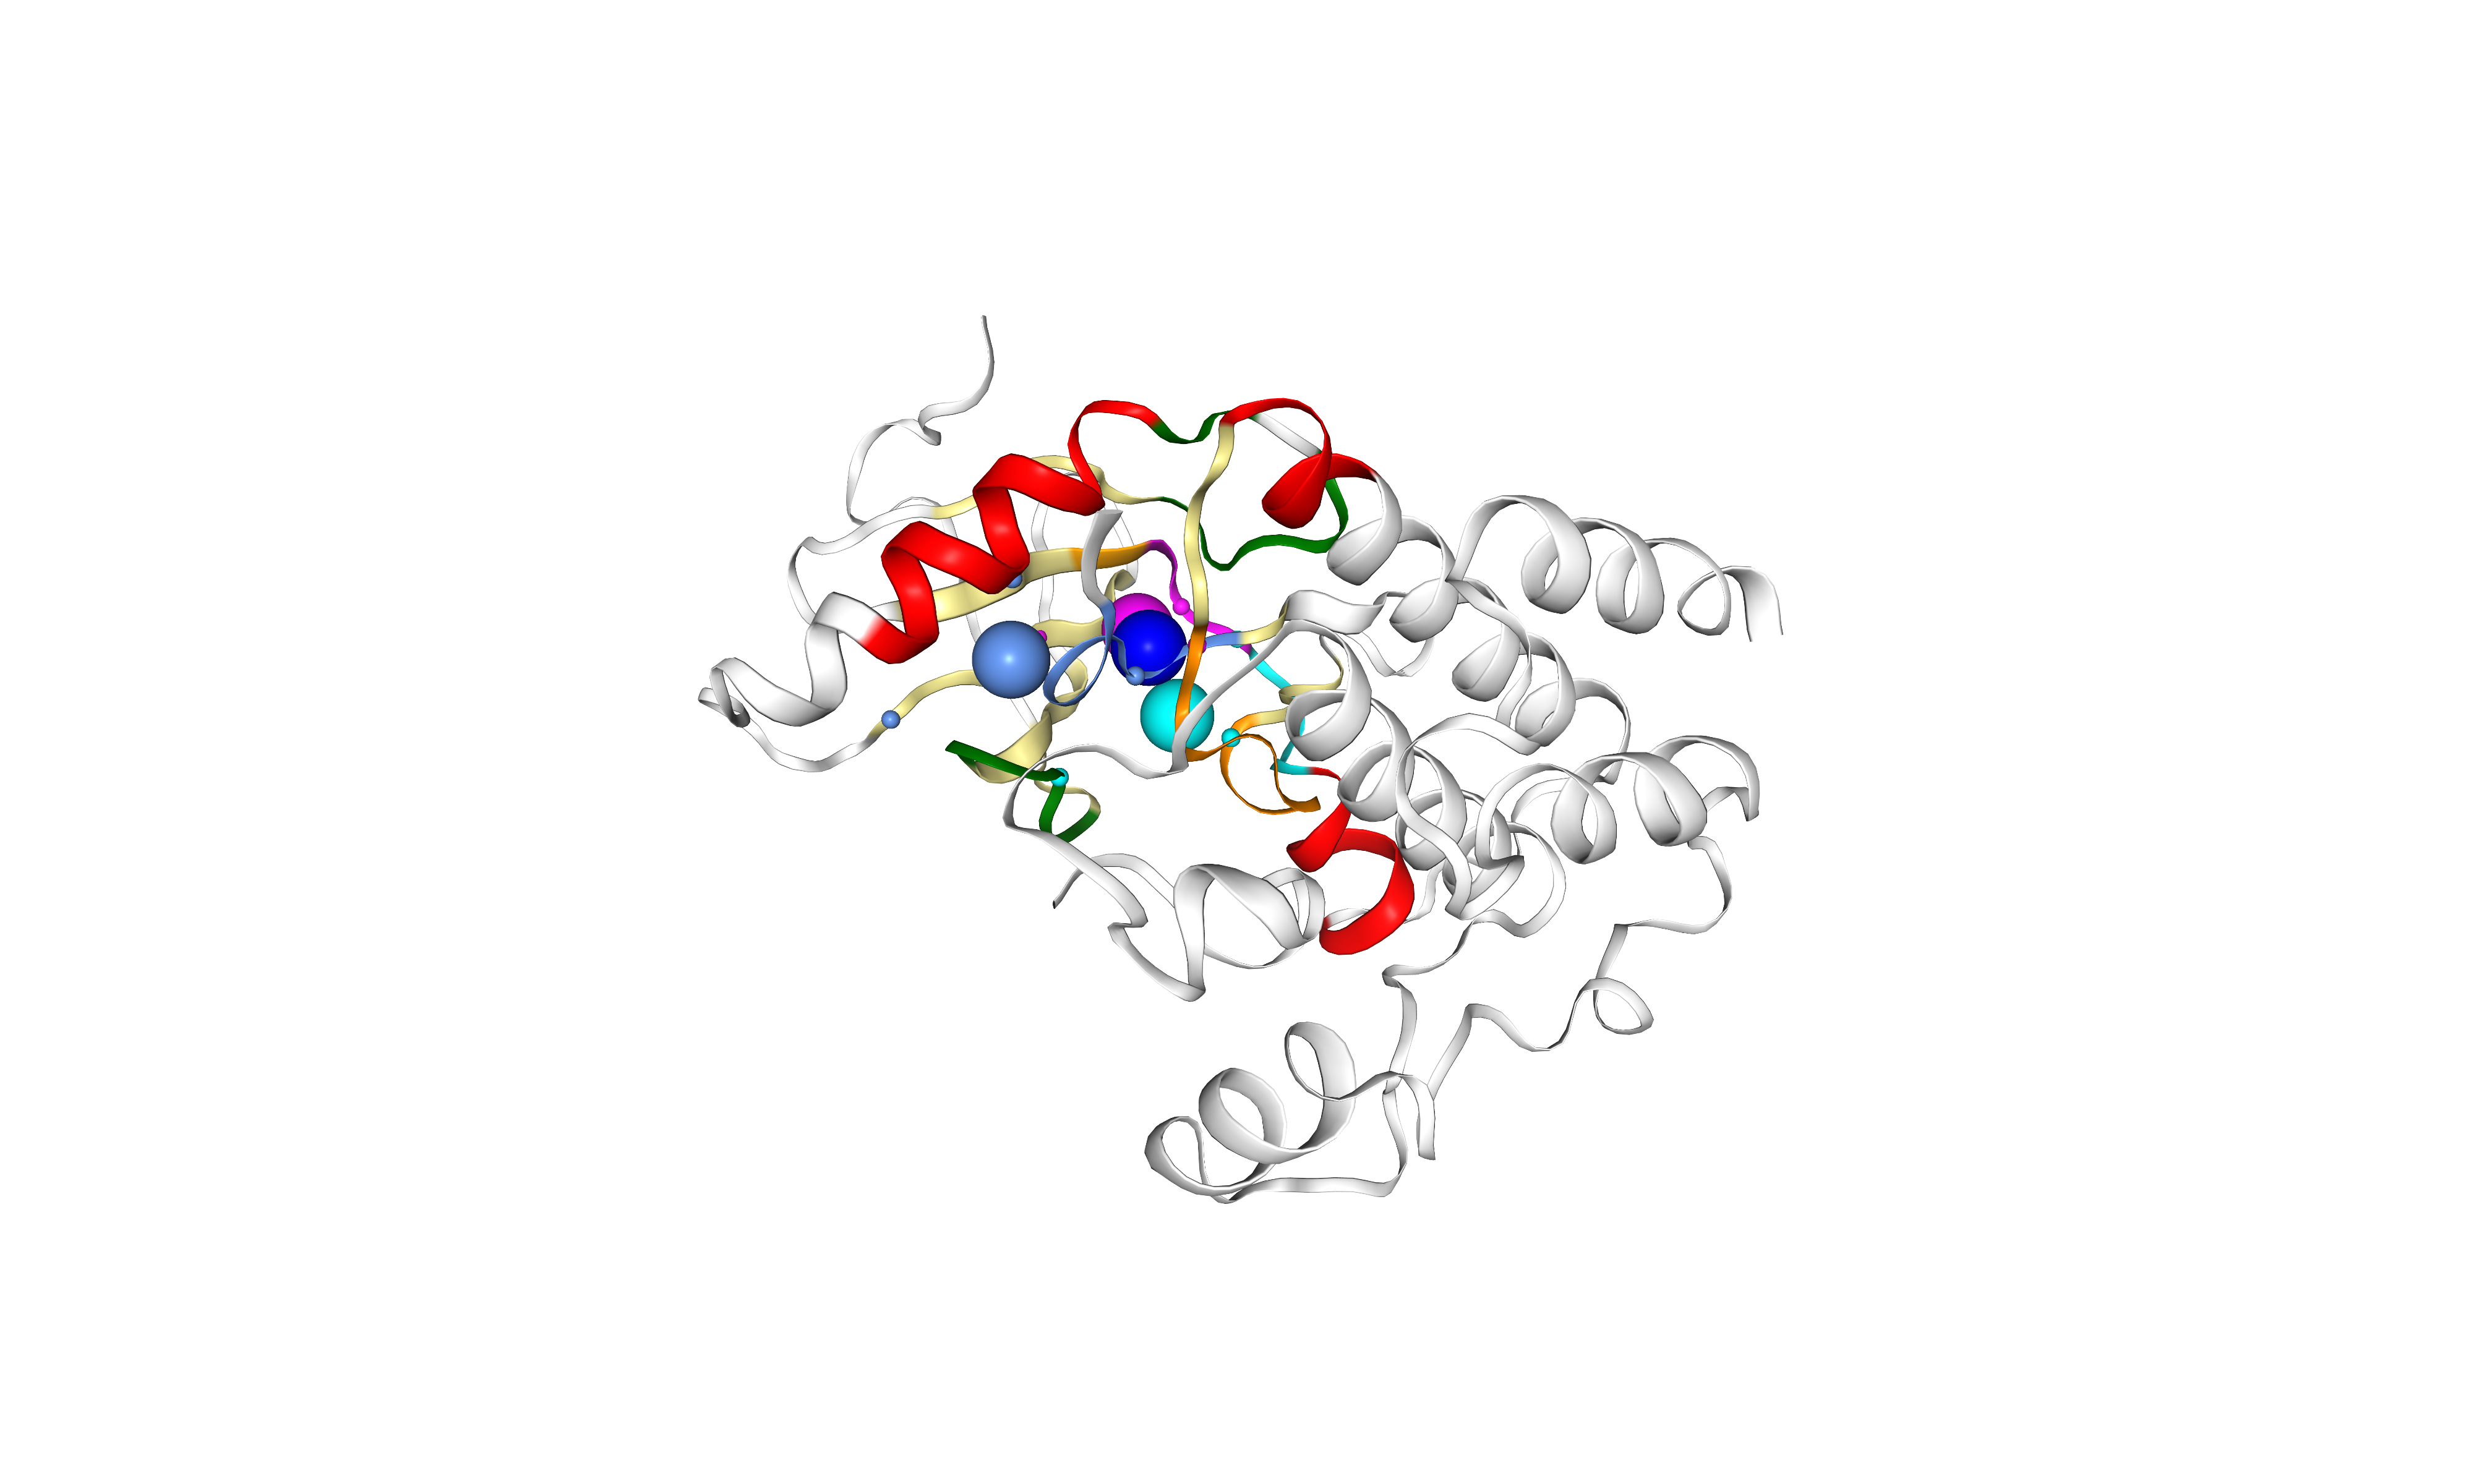

In [16]:
view._display_image()

### CIDO (KLIFS: CODI) structure

In [17]:
structure = structures_selected.iloc[1]
structure

structure.ung_conformation                                   CIDO
structure.pdb                                                4ehg
structure.id                                                 3078
structure.dfg                                                  in
structure.ac_helix                                            out
species.klifs                                               Human
kinase.name                                                  BRAF
structure.alternate_model                                       -
structure.chain                                                 B
structure.filepath            HUMAN_BRAF_4ehg_chainB_protein.mol2
Name: 1, dtype: object

In [18]:
structure_id = structure["structure.id"]
filepath = structure["structure.filepath"]
name = structure["structure.ung_conformation"]

view = visualize_kinase(structure_id, filepath, KINASE_SUBPOCKETS, name)
view

The pocket centroid is calculated based on 84 CA atoms.


NGLWidget()

In [19]:
view.render_image(),

(Image(value=b'', width='99%'),)

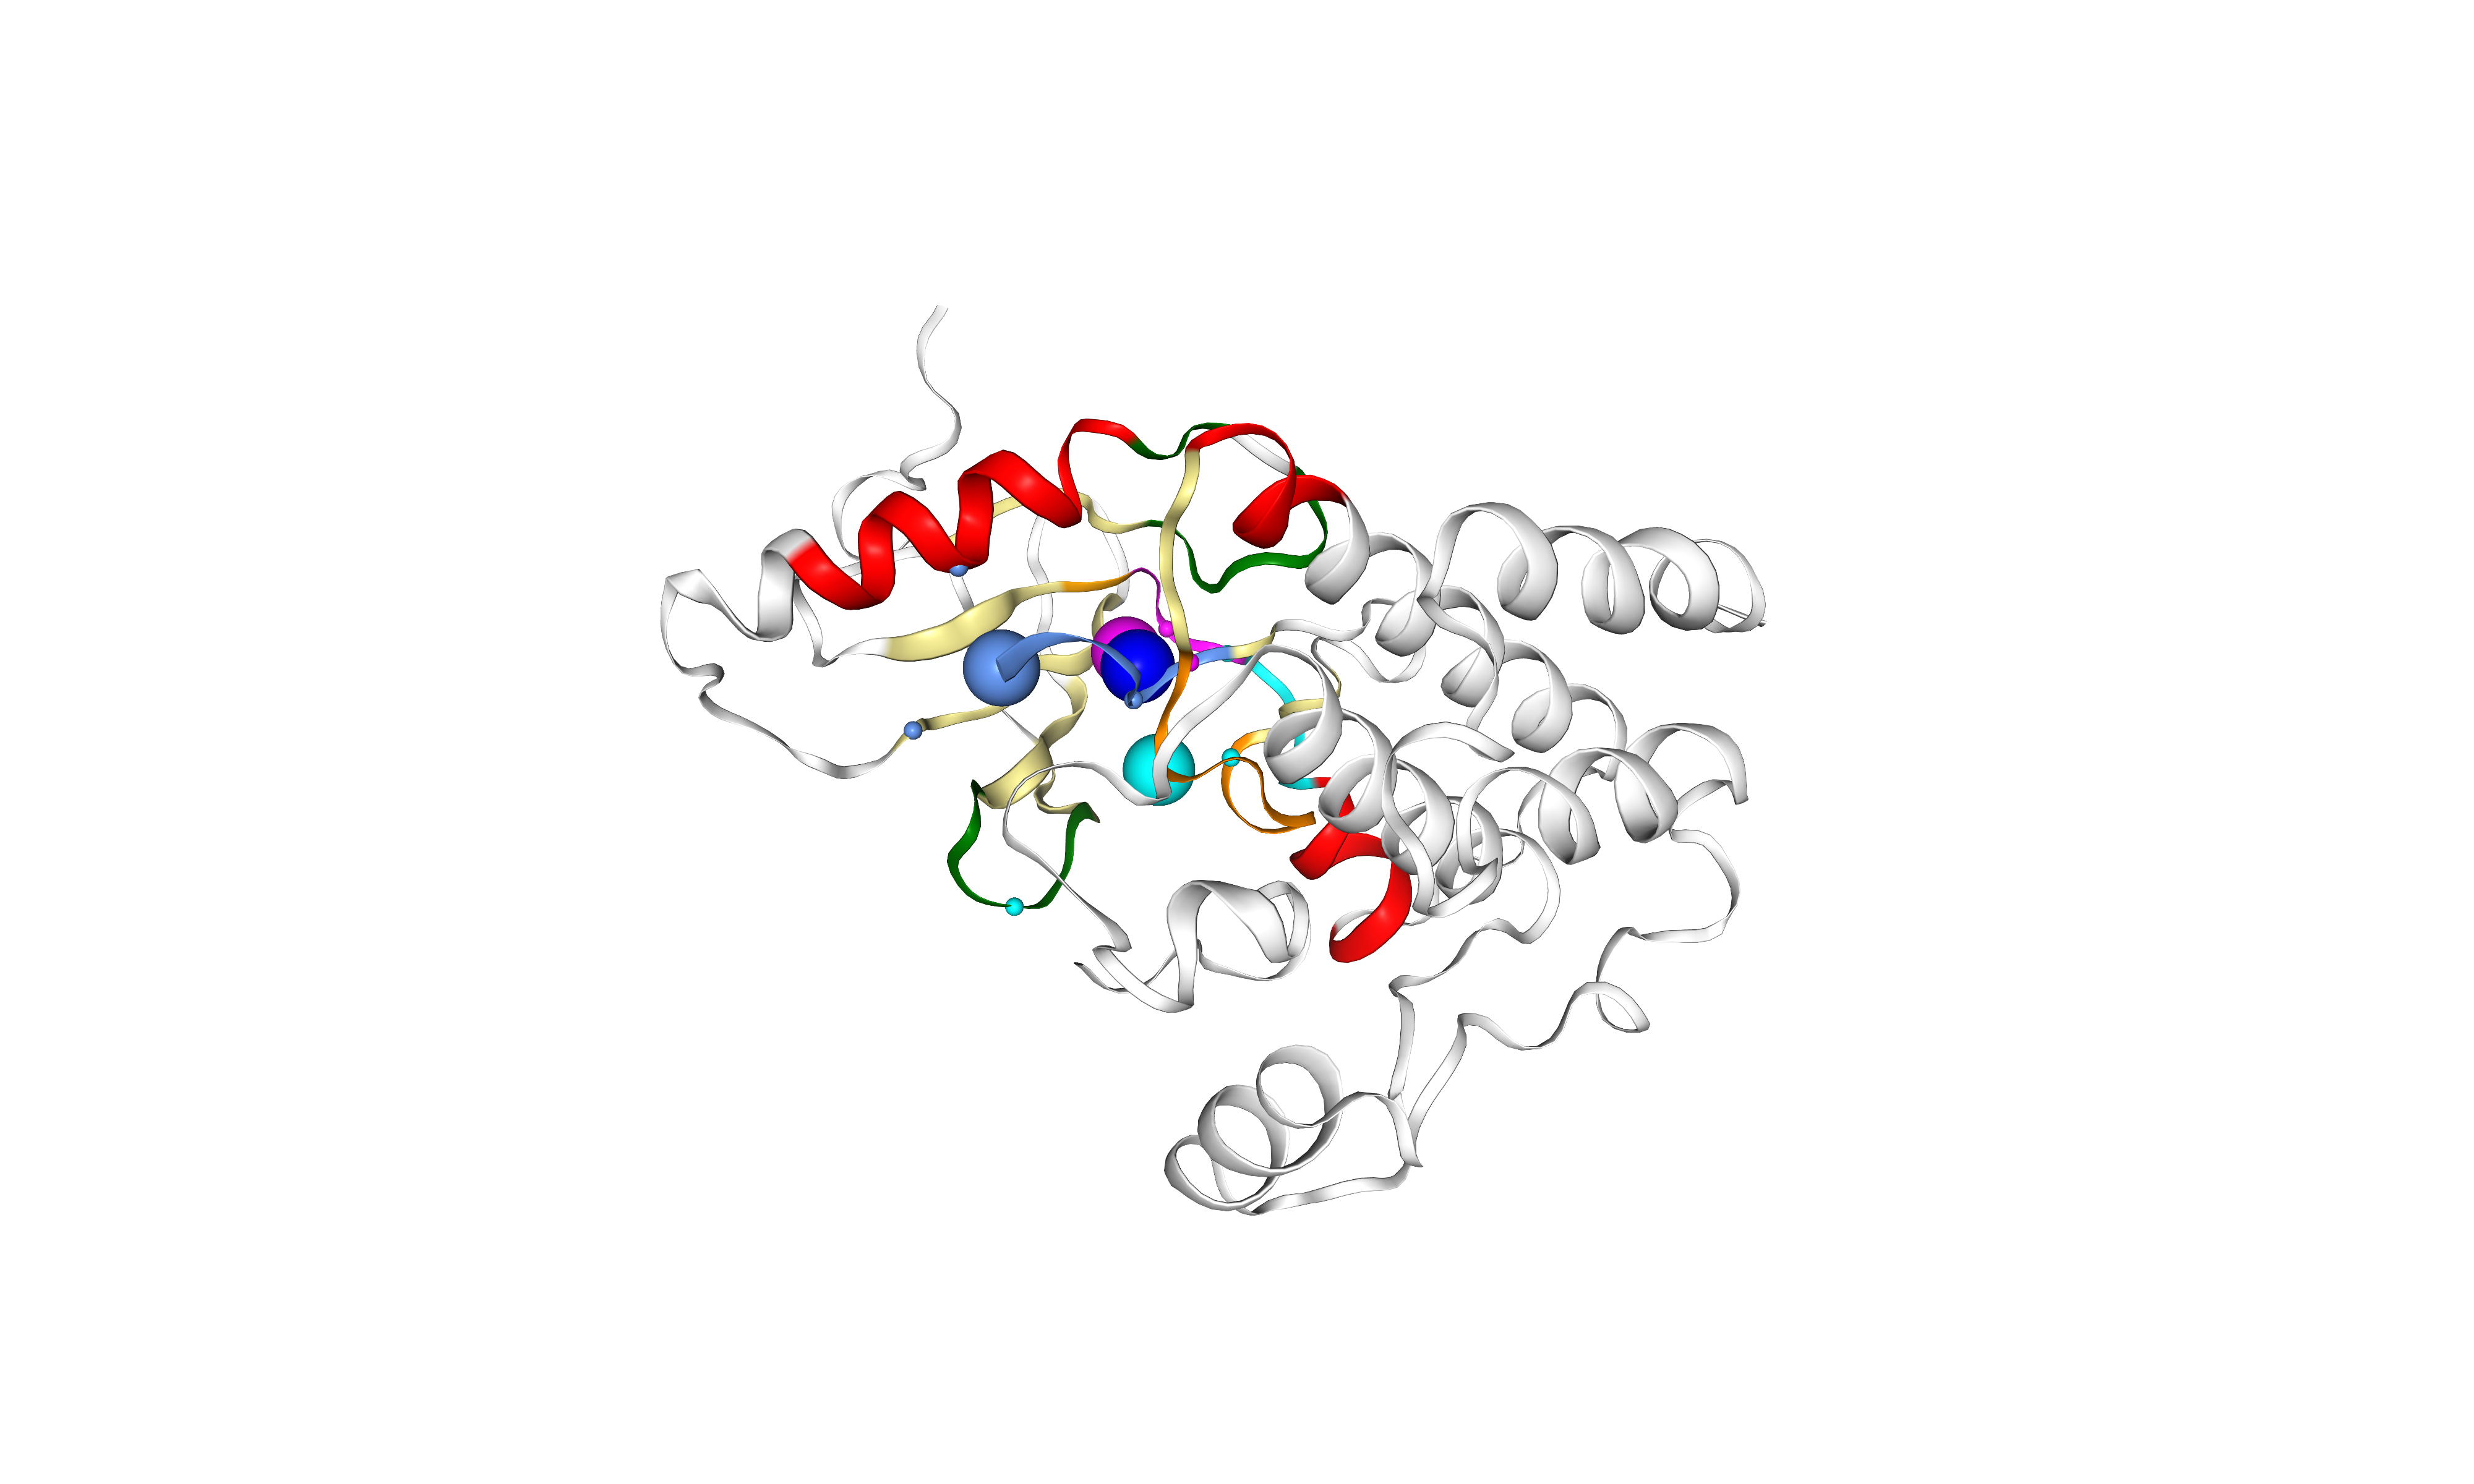

In [20]:
view._display_image()

### CODI (KLIFS: CODO) structure

In [21]:
structure = structures_selected.iloc[2]
structure

structure.ung_conformation                                   CODI
structure.pdb                                                1uwh
structure.id                                                 3127
structure.dfg                                                 out
structure.ac_helix                                            out
species.klifs                                               Human
kinase.name                                                  BRAF
structure.alternate_model                                       -
structure.chain                                                 A
structure.filepath            HUMAN_BRAF_1uwh_chainA_protein.mol2
Name: 2, dtype: object

In [22]:
structure_id = structure["structure.id"]
filepath = structure["structure.filepath"]
name = structure["structure.ung_conformation"]

view = visualize_kinase(structure_id, filepath, KINASE_SUBPOCKETS, name)
view

The pocket centroid is calculated based on 85 CA atoms.


NGLWidget()

In [23]:
view.render_image(),

(Image(value=b'', width='99%'),)

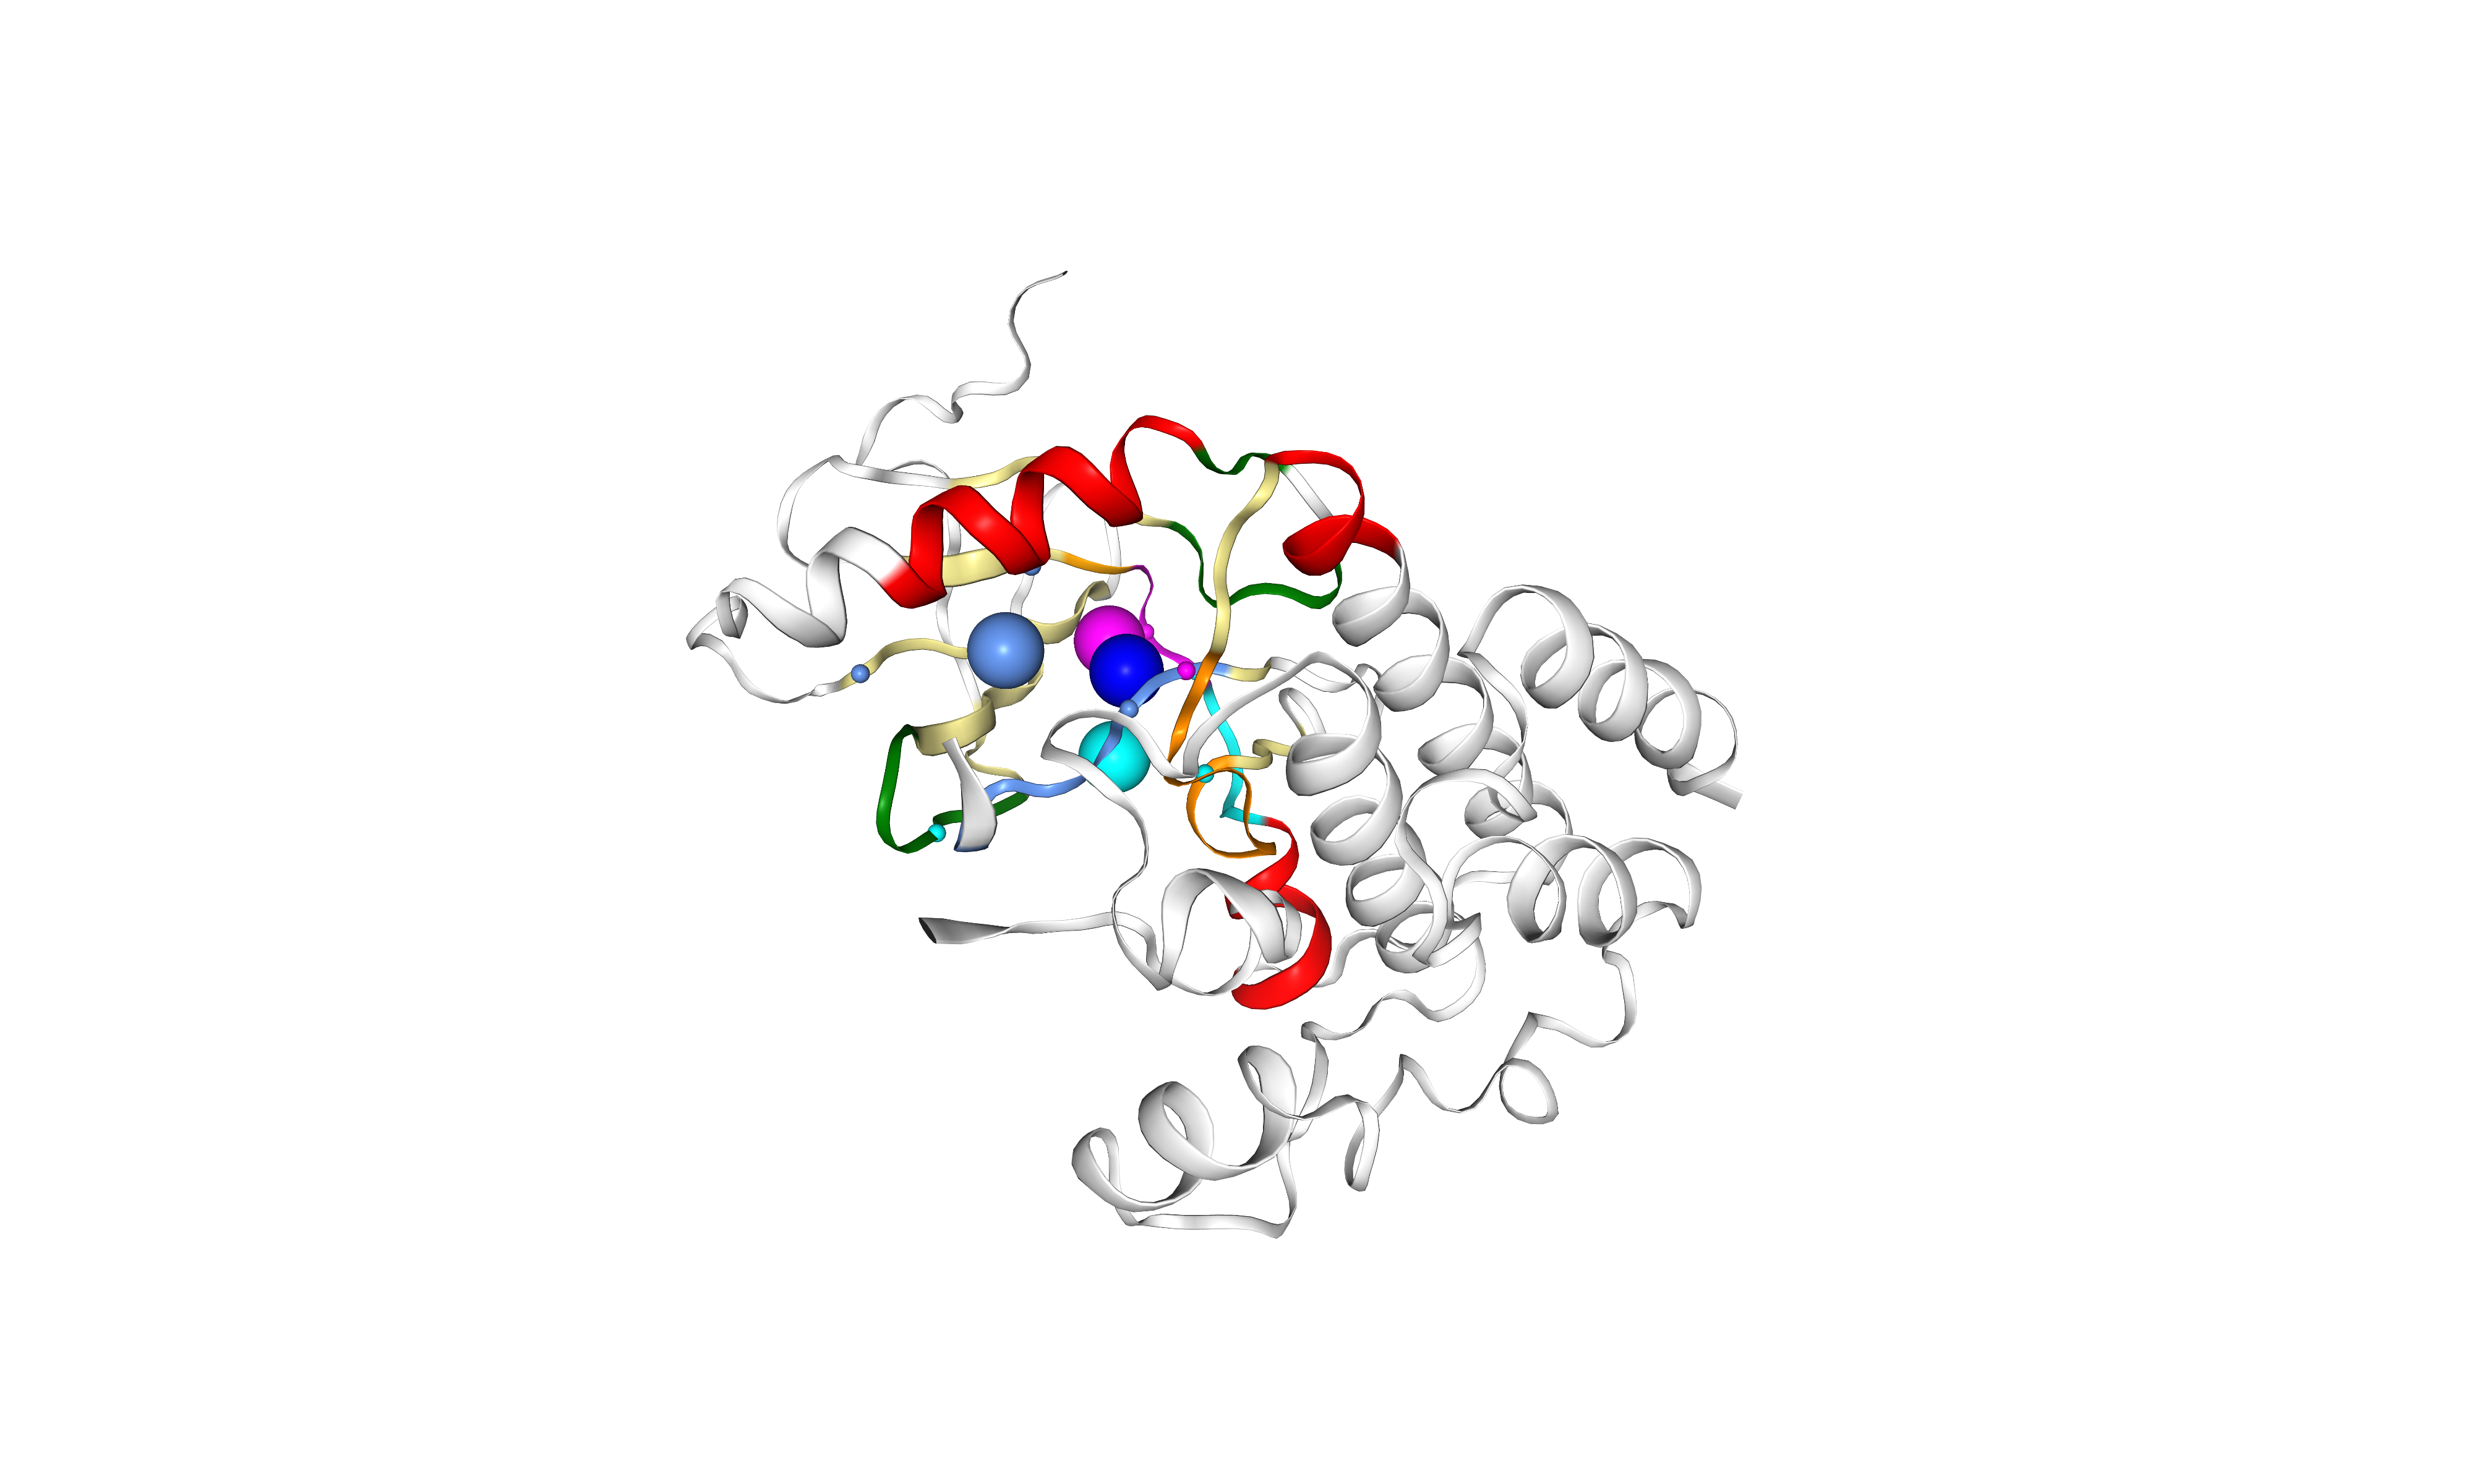

In [24]:
view._display_image()

### CODO (KLIFS: CODI) structure

In [25]:
structure = structures_selected.iloc[3]
structure

structure.ung_conformation                                        CODO
structure.pdb                                                     4xv9
structure.id                                                      6215
structure.dfg                                                       in
structure.ac_helix                                                 out
species.klifs                                                    Human
kinase.name                                                       BRAF
structure.alternate_model                                            B
structure.chain                                                      A
structure.filepath            HUMAN_BRAF_4xv9_altB_chainA_protein.mol2
Name: 3, dtype: object

In [26]:
structure_id = structure["structure.id"]
filepath = structure["structure.filepath"]
name = structure["structure.ung_conformation"]

view = visualize_kinase(structure_id, filepath, KINASE_SUBPOCKETS, name)
view

The pocket centroid is calculated based on 85 CA atoms.


NGLWidget()

In [27]:
view.render_image(),

(Image(value=b'', width='99%'),)

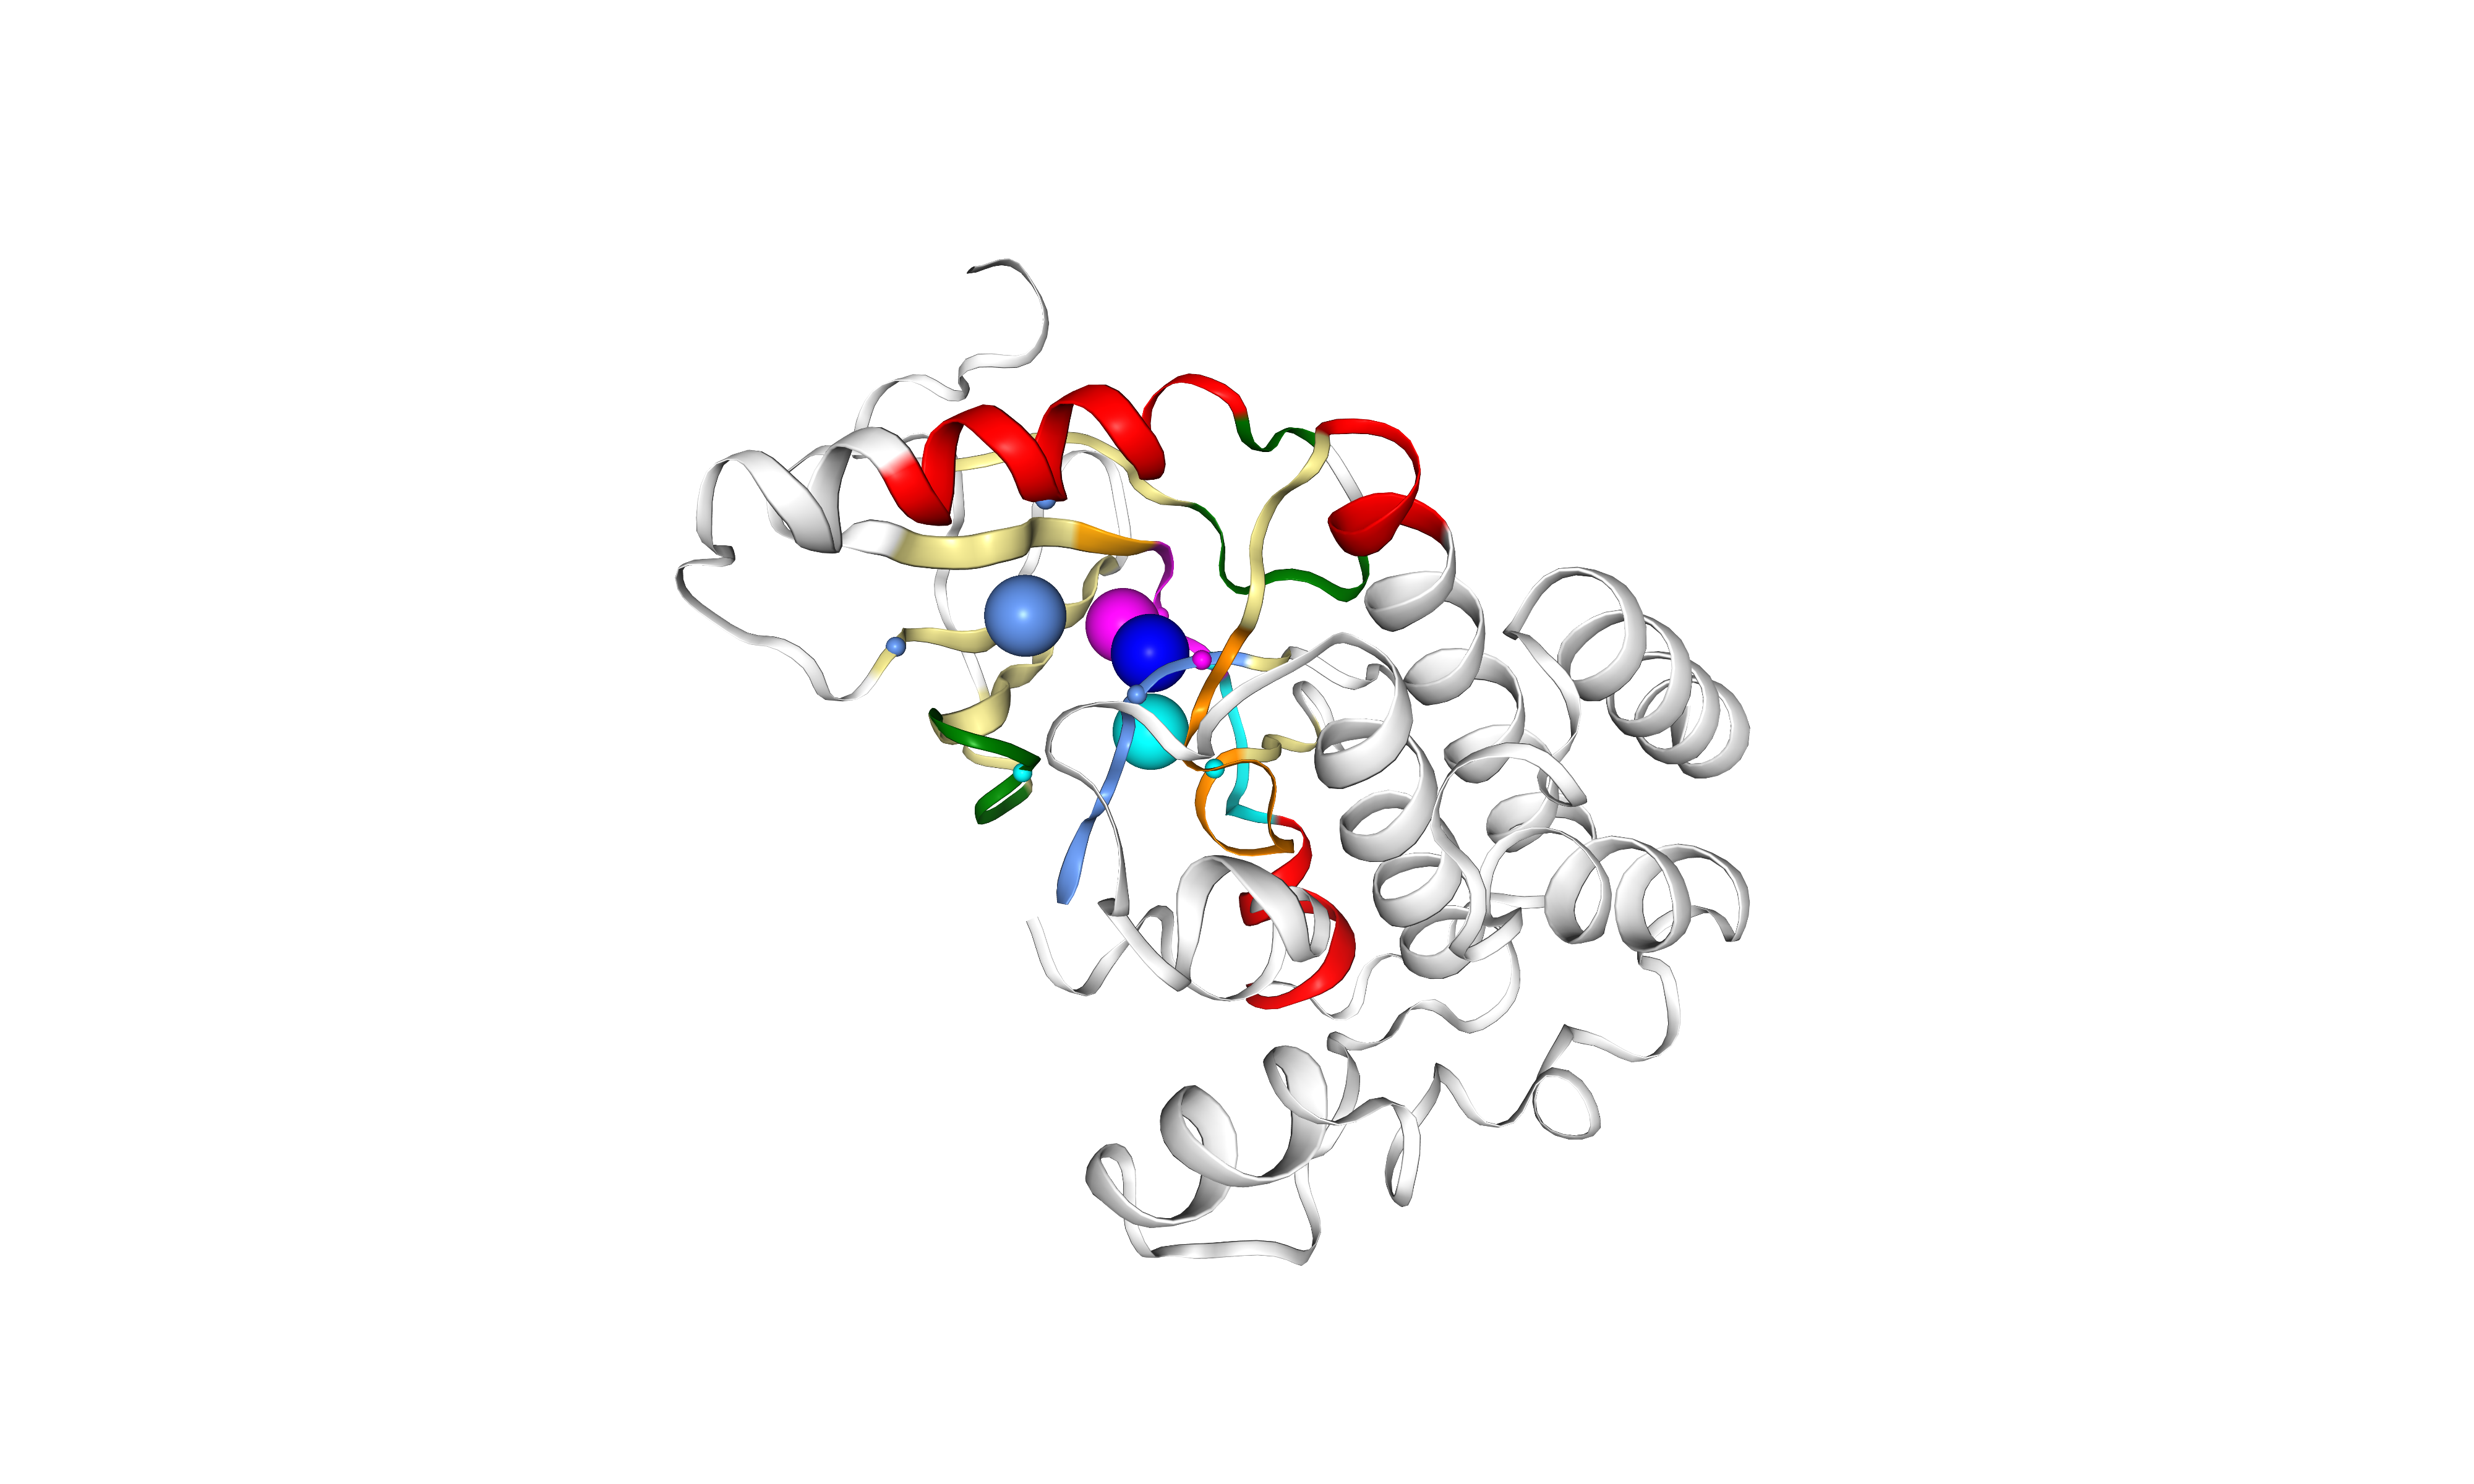

In [28]:
view._display_image()

In [29]:
structures_selected["structure.filepath"].apply(lambda x: Path(x).unlink());